# Structure Search

## Objectives
- Learn various types of structure searches including identity search, similarity search, substructure and super structure searches.
- Learn the optional parameters available for each search type.


Using PUG-REST, one can perform various types of structure searches (https://bit.ly/2lPznCo), including:
- identity search
- similarity search
- super/substructure search
- molecular formula search
<br>

As explained in a PubChem paper (https://bit.ly/2kirxky), whereas structure search can be performed in either an 'asynchronous' or 'synchronous' way, it is highly recommended to use the synchronous approach.<br>
The synchronous searches are invoked by using the keywords prefixed with ‘fast’, such as **fastidenity**, **fastsimilarity_2d**, **fastsimilarity_3d**, **fastsubstructure**, **fastsuperstructure**, and **fastformula**.

<div class="alert alert-block alert-warning">
Note: To use the python code in this lesson plan, RDKit must be installed on the system. 
</div>

Many users can simply run the following code to install RDKit.

Access to the full installation instructions can be found at the following link.
https://www.rdkit.org/docs/Install.html

## 1. Identity Search

PUG-REST allows you to search the PubChem Compound database for molecules identical to the query molecule.  PubChem's identity search supports different contexts of chemical identity, which the user can specify using the optional parameter, "identity_type".  Here are some commonly-used chemical identity contexts.
- **same_connectivity**: returns compounds with the same atom connectivity as the query molecule, ignoring stereochemistry and isotope information.
- **same_isotope**: returns compounds with the same isotopes (as well as the same atom connectivity) as the query molecule.  Stereochemistry will be ignored.
- **same_stereo**: returns compounds with the same stereochemistry (as well as the same atom connectivity) as the query molecule.  Isotope information will be ignored.
- **same_stereo_isotope**: returns compounds with the same stereochemistry AND isotope information (as well as the same atom connectivity).  This is the default.

The following code cell demostrates how these different contexts of chemical sameness affects identity search in PubChem.

In [1]:
import requests
import time
import io

from rdkit import Chem
from rdkit.Chem import Draw

prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

mydata = { 'smiles' : 'C(/C=C/Cl)Cl' }
options = [ 'same_stereo_isotope', # This is the default
            'same_stereo',
            'same_isotope',
            'same_connectivity']

for myoption in ( options ) :

    print("#### Identity_type:", myoption)
    
    url = prolog + '/compound/fastidentity/smiles/property/isomericsmiles/csv?identity_type=' + myoption
    res = requests.post(url, data=mydata)
    
    mycids = []
    mysmiles = []
    
    file = io.StringIO(res.text)
    file.readline()               # Skip the first line (column heads)
    
    for line in file :
        
        ( cid_tmp, smiles_tmp ) = line.rstrip().split(',')
        print(cid_tmp, smiles_tmp)
        
        mycids.append( cid_tmp )
        mysmiles.append( smiles_tmp.replace('"',"") )

    mols = []
    
    for x in mysmiles :
        
        mol = Chem.MolFromSmiles(x)
        Chem.FindPotentialStereoBonds(mol)    # Identify potential stereo bonds!
        mols.append(mol)
    
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200), legends=mycids)
    display(img)
            
    time.sleep(0.2)

ModuleNotFoundError: No module named 'rdkit'

**Exercise 1a:** Find compounds that has the same atom connectivity and isotope information as the query molecule.

In [2]:
query = "CC1=CN=C(C(=C1OC)C)C[S@](=O)C2=NC3=C(N2)C=C(C=C3)OC"

For each compound returned from the search, retrieve the following information.
- CID
- Isomeric SMILES string
- chemical synonyms (for simplicity, print only the five synonyms that first occur in the name list retrieved for each compound)
- Structure image


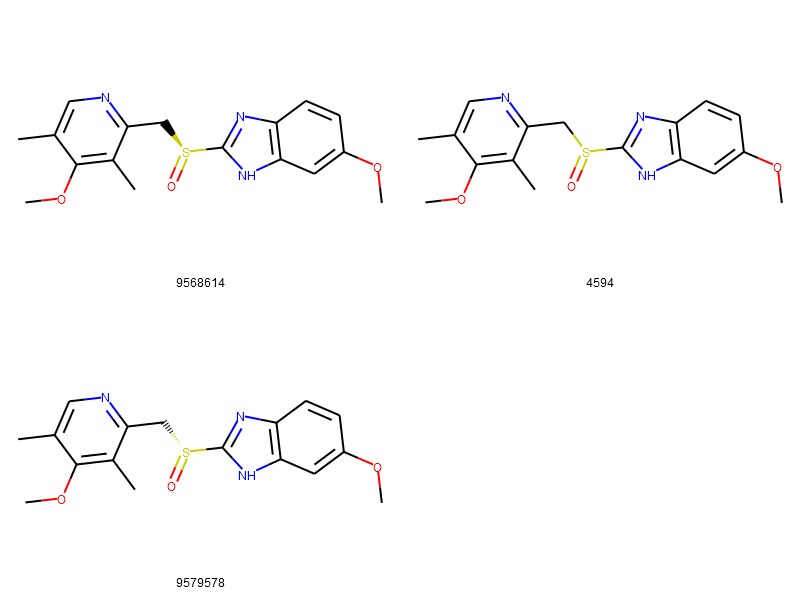

CID 9568614
	 CC1=CN=C(C(=C1OC)C)C[S@](=O)C2=NC3=C(N2)C=C(C=C3)OC
	 ['Esomeprazole', '(S)-Omeprazole', '119141-88-7', '(-)-Omeprazole', '(S)-(-)-Omeprazole']
CID 4594
	 CC1=CN=C(C(=C1OC)C)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC
	 ['omeprazole', '73590-58-6', 'Losec', 'Prilosec', 'Antra']
CID 9579578
	 CC1=CN=C(C(=C1OC)C)C[S@@](=O)C2=NC3=C(N2)C=C(C=C3)OC
	 ['Esomeprazole', '(r)-omeprazole', '119141-89-8', '(R)-5-Methoxy-2-(((4-methoxy-3,5-dimethylpyridin-2-yl)methyl)sulfinyl)-1H-benzo[d]imidazole', 'AK101106']


In [3]:
# Write your code in this cell.

import requests
import time
import io

from rdkit import Chem
from rdkit.Chem import Draw

prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

mydata = {'smiles' : query }
url = prolog + '/compound/fastidentity/smiles/property/isomericsmiles/csv?identity_type=same_isotope'
res = requests.post(url, data=mydata)
    
mycids = []
mysmiles = []
    
file = io.StringIO(res.text)
file.readline()               # Skip the first line (column heads)
    
for line in file :
        
    ( cid_tmp, smiles_tmp ) = line.rstrip().split(',')
    mycids.append( cid_tmp )
    mysmiles.append( smiles_tmp.replace('"',"") )

mols = []
    
for x in mysmiles :
        
    mol = Chem.MolFromSmiles(x)
    Chem.FindPotentialStereoBonds(mol)    # Identify potential stereo bonds
    mols.append(mol)
    
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400,300), legends=mycids)
display(img)

for i in range(len(mycids)) :
    
    url = prolog + '/compound/cid/' + mycids[i] + '/synonyms/TXT'
    res = requests.get(url)
    mysynonyms = res.text.split()
    print("CID", mycids[i])
    print("\t", mysmiles[i])
    print("\t", mysynonyms[0:5])
    
    time.sleep(0.2)


## 2. Similarity search

PubChem supports 2-dimensional (2-D) and 3-dimensional (3-D) similarity searches.  Because molecular similarity is not a measurable physical observable but a subjective concept, many approaches have been developed to evaluate it.  Detailed discussion on how PubChem quantifyies molecular similarity, read the following LibreTexts page:
    
**Searching PubChem Using a Non-Textual Query** (https://bit.ly/2lPznCo)


The code cell below demonstrates how to perform 2-D and 3-D similarity searches.

In [4]:
mydata = { 'smiles' : "C1COCC(=O)N1C2=CC=C(C=C2)N3C[C@@H](OC3=O)CNC(=O)C4=CC=C(S4)Cl" }
url = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt?Threshold=99"
res = requests.post(url,data=mydata)
cids = res.text.split()

print("# Number of CIDs:", len(cids))
print(cids)

# Number of CIDs: 29
['9875401', '6433119', '11524901', '68152323', '25190310', '25164166', '123868009', '56598114', '25255944', '11994745', '25190129', '25190130', '25190186', '25190187', '25190188', '25190189', '25190190', '25190248', '25190249', '25190250', '25190251', '25190252', '25190311', '25255845', '25255945', '25255946', '49849874', '56589668', '133687098']


It is worth mentioning that the parameter name "Threshold" is **case-sensitive**.  If "threshold" is used (rather than "Threshold"), it will be ignored and the default value (0.90) will be used for the parameter.  \[As a matter of fact, all optional parameter names in PUG-REST are case-sensitive.]

In [5]:
url1 = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt?Threshold=95"
url2 = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt?threshold=95"  # "threshold=95" is ignored.

res1 = requests.post(url1,data=mydata)
res2 = requests.post(url2,data=mydata)
cids1 = res1.text.split()
cids2 = res2.text.split()

print("# Number of CIDs:", len(cids1), "vs.", len(cids2))

# Number of CIDs: 165 vs. 763


It is possible to run 3-D similarity search using PUG-REST.  However, because 3-D similarity search takes much longer than 2-D similarity search, it often exceeds the 30-second time limit and returns a time-out error, especially when the query molecule is big.

In addition, for 3-D similarity search, it is **not** possible to adjust the similarity threshold (that is, the optional "Threshold" parameter does not work).  3-D similarity search uses a shape-Tanimoto (ST) of >=0.80 and a color-Tanimoto (CT) of >=0.50 as a similarity threshold.  Read the libreTexts page for more details (https://bit.ly/2lPznCo).

In [6]:
mydata = { 'smiles' : 'CC(=O)OC1=CC=CC=C1C(=O)O'}
url = prolog + "/compound/fastsimilarity_3d/smiles/cids/txt"
res = requests.post(url, data=mydata)
cids = res.text.split()
print(len(cids))

21424


**Exercise 2a:** Perform 2-D similarity search with the following query, using a threshold of 0.80 and find the macromolecule targets of the assays in which the returned compounds were tested.  You will need to take these steps.

- Run 2-D similarity search using the SMILES string as a query (with Threshold=80).
- Retrieve the AIDs in which any of the returned CIDs was tested "active".
- Retrieve the gene symbols of the targets for the returned AIDs.

In [7]:
query='[C@@H]23C(=O)[C@H](N)C(C)[C@H](CCC1=COC=C1)[C@@]2(C)CCCC3(C)C'

In [8]:
# Write your code in this cell.

mydata = { 'smiles' : query }
url = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt?Threshold=80"
res = requests.post(url, data=mydata)
cids = res.text.split()
print("# Number of CIDs:", len(cids))

chunk_size = 50

if len(cids) % chunk_size == 0 :
    num_chunks = int( len(cids) / chunk_size )
else :
    num_chunks = int( len(cids) / chunk_size ) + 1

aids = []
    
for i in range(num_chunks):
    
    print("Processing chunk", i)
    
    idx1 = chunk_size * i
    idx2 = chunk_size * (i + 1)
    str_cids = ",".join(cids[idx1:idx2])

    url = prolog + "/compound/cid/" + str_cids + "/aids/txt?aids_type=active"
    res = requests.get(url)

    if ( res.status_code == 200) :
        aids.extend( res.text.split() )
        
    time.sleep(0.2)

aids= list(set(aids))
print("# Number of AIDs:", len(aids))
    
url = prolog + "/assay/aid/" + ",".join(aids) + "/targets/GeneSymbol/TXT"
res = requests.get(url)
targets = set( res.text.split() )
print(targets)

# Number of CIDs: 2437
Processing chunk 0
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Processing chunk 13
Processing chunk 14
Processing chunk 15
Processing chunk 16
Processing chunk 17
Processing chunk 18
Processing chunk 19
Processing chunk 20
Processing chunk 21
Processing chunk 22
Processing chunk 23
Processing chunk 24
Processing chunk 25
Processing chunk 26
Processing chunk 27
Processing chunk 28
Processing chunk 29
Processing chunk 30
Processing chunk 31
Processing chunk 32
Processing chunk 33
Processing chunk 34
Processing chunk 35
Processing chunk 36
Processing chunk 37
Processing chunk 38
Processing chunk 39
Processing chunk 40
Processing chunk 41
Processing chunk 42
Processing chunk 43
Processing chunk 44
Processing chunk 45
Processing chunk 46
Processing chunk 47
Processing chunk 48
# Numbe

## 3. Substructure/Superstructure search

When a chemical structure occurs as a part of a bigger chemical structure, the former is called a substructure and the latter is referred to as a superstructure (https://bit.ly/2lPznCo).  PUG-REST supports both substructure and superstructure searches.  For example, below is an example for substructure search using the core structure of antibiotic drugs called cephalosporins as a query (https://en.wikipedia.org/wiki/Cephalosporin). 

In [9]:
query = 'C12(SCC(=C(N1C([C@H]2NC(=O)[*])=O)C(=O)O[H])[*])[H]'

mydata = { 'smiles' : query }
url = prolog + "/compound/fastsubstructure/smiles/cids/txt?Stereo=exact"
res = requests.post(url, data=mydata)
cids = res.text.split()

print("# Number of CIDs:", len(cids))
#print(cids)

# Number of CIDs: 21810


An important thing to remember about substructure search is that, if the query structure is not specific enough (that is, not big enough), it will return too many hits for the PubChem server can handle.  For example, if you perform substructure search using the "C-C" as a query, it will give you an error, because PubChem has ~96 million (organic) compounds with more than two carbon atoms and most of them will have the "C-C" unit. Therefore, if you get an "time-out" error while doing substructure search, consider providing more specific structure as an input query.

**Exercise 3a:** Below is the SMILES string for a HCV (Hepatitis C Virus) drug (Sovaldi).  Perform substructure search using this SMILES string as a query, identify compounds that are mentioned in patent documents, and create a list of the patent documents that mentioning them.

- Use the default options for substructure search.
- Use the "XRefs" operation to retrieve Patent IDs associated with the returned compounds.
- For simplicity, ignore the CID-Patent ID mapping.  (That is, no need to track which CID is associated with which patent document.)

In [10]:
query="C[C@@H](C(=O)OC(C)C)N[P@](=O)(OC[C@@H]1[C@H]([C@@]([C@@H](O1)N2C=CC(=O)NC2=O)(C)F)O)OC3=CC=CC=C3"

In [11]:
# Write your code in this cell.

mydata = { 'smiles' : query }
url = prolog + "/compound/fastsubstructure/smiles/cids/txt"
res = requests.post(url, data=mydata)
cids = res.text.split()
print("# Number of CIDs:", len(cids))

chunk_size = 50

if len(cids) % chunk_size == 0 :
    num_chunks = int( len(cids) / chunk_size )
else :
    num_chunks = int( len(cids) / chunk_size ) + 1

patentids = []
    
for i in range(num_chunks):
    
    print("Processing chunk", i)
    
    idx1 = chunk_size * i
    idx2 = chunk_size * (i + 1)
    str_cids = ",".join(cids[idx1:idx2])
    
    url = prolog + "/compound/cid/" + str_cids + "/XRefs/PatentID/txt"
    res = requests.get(url)
    
    if ( res.status_code == 200 ) :
        patentids.extend( res.text.split() )
    
    time.sleep(0.2)

unique_patentids = sorted( set( patentids ) )
print("# Number of Patent IDs:", len(unique_patentids))
print(unique_patentids)

# Number of CIDs: 612
Processing chunk 0
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
# Number of Patent IDs: 487
['EP2203462A2', 'EP2203462B1', 'EP2376514A2', 'EP2432792A1', 'EP2432792B1', 'EP2552930A2', 'EP2552930B1', 'EP2552931A2', 'EP2552931B1', 'EP2596004B1', 'EP2609923A2', 'EP2609923B1', 'EP2610264A2', 'EP2655392B1', 'EP2696679B1', 'EP2709613A2', 'EP2709613B1', 'EP2752422A1', 'EP2752422B1', 'EP2792680A1', 'EP2801580A1', 'EP2805960A1', 'EP2824109A1', 'EP2826784A1', 'EP2826784B1', 'EP2855478B1', 'EP2909223B1', 'EP2910562A1', 'EP2913337A1', 'EP2913337B1', 'EP2916840A1', 'EP2920192A1', 'EP2920192B1', 'EP2933260A1', 'EP2940031A1', 'EP2940031B1', 'EP2950786A1', 'EP2959888A1', 'EP2959891A1', 'EP2959901A1', 'EP2977379A1', 'EP2984097B1', 'EP2998307A1', 'EP3038601A1', 'EP3041855B1', 'EP3086795A1', 'EP310792

## 4. Molecular formula search

Strictly speaking, molecular formula search is not structure search, but its PUG-REST request URL is constructed in a similar way to structure searches like identity, similarity, and substructure/superstructure searches.

In [12]:
query = 'C22H28FN3O6S'    # Molecular formula for Crestor (Rosuvastatin: CID 446157)

url = prolog + "/compound/fastformula/"+ query + "/cids/txt"
res = requests.get(url)
cids = res.text.split()
print("# Number of CIDs:", len(cids))
#print(cids)

# Number of CIDs: 179


It is possible to allow other elements to be present in addition to those specified by the query formula, as shown in the following example.


In [13]:
url = prolog + "/compound/fastformula/"+ query + "/cids/txt?AllowOtherElements=true"
res = requests.get(url)
cids = res.text.split()
print("# Number of CIDs:", len(cids))
#print(cids)

# Number of CIDs: 200


**Exercise 4a:**  The general molecular formula for alcohols is $C_{n}H_{(2n+2)}O$ \[for example, CH4O (methanol), C2H6O (ethanol), C3H8O (propanol), etc].  Run molecular formula search using this general formula for n=1 through 20 and retrieve the XLogP values of the returned compounds for each value of n.  Print the minimum and maximum XLogP values for each n value.

In [14]:
# Write your code in this cell.

for i in range(1,21) :
    
    num_C = i
    num_H = 2*i + 2
    
    formula = 'C' + str(num_C) + 'H' + str(num_H) + 'O'
    
    url = prolog + "/compound/fastformula/"+ formula + "/property/xlogp/txt"
    res = requests.get(url)
    xlogp = res.text.split()
    print("n=", i, "(", len(xlogp) ,"CIDs )", ":", min(xlogp), max(xlogp) )
    
    time.sleep(0.2)

n= 1 ( 33 CIDs ) : -0.5 -0.500
n= 2 ( 54 CIDs ) : -0.1 0.1
n= 3 ( 60 CIDs ) : 0.3 0.400
n= 4 ( 84 CIDs ) : 0.5 1.200
n= 5 ( 84 CIDs ) : 0.900 1.700
n= 6 ( 123 CIDs ) : 1.4 2.000
n= 7 ( 203 CIDs ) : 1.8 2.900
n= 8 ( 452 CIDs ) : 2.0 3.500
n= 9 ( 712 CIDs ) : 2.6 4.300
n= 10 ( 992 CIDs ) : 2.9 4.800
n= 11 ( 1014 CIDs ) : 3.4 5.100
n= 12 ( 904 CIDs ) : 3.7 5.400
n= 13 ( 658 CIDs ) : 4.2 6.100
n= 14 ( 595 CIDs ) : 4.6 6.700
n= 15 ( 488 CIDs ) : 5.0 7.000
n= 16 ( 510 CIDs ) : 5.4 7.500
n= 17 ( 286 CIDs ) : 6.0 8.300
n= 18 ( 363 CIDs ) : 6.2 8.600
n= 19 ( 170 CIDs ) : 6.7 9.100
n= 20 ( 268 CIDs ) : 7.0 9.500
